Jonas Wagner, jrw200000

In [1]:
import networkx as nx
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
from numpy import *
from numpy.linalg import eig,norm
import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
from time import time
from copy import deepcopy
import asyncio
import colorsys

The following functions assist in coloring nodes based on the value of the state at each node. You will only need to use `color_by_value` - the rest of the functions are helper functions that are used behind the scenes.

In [2]:
def RGBToHTMLColor(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBB """
    hexcolor = '#%02x%02x%02x' % rgb_tuple
    # that's it! '%02x' means zero-padded, 2-digit hex values
    return hexcolor

def HTMLColorToRGB(colorstring):
    """ convert #RRGGBB to an (R, G, B) tuple """
    colorstring = colorstring.strip()
    if colorstring[0] == '#': colorstring = colorstring[1:]
    if len(colorstring) != 6:
        raise ValueError("input #%s is not in #RRGGBB format" % colorstring)
    r, g, b = colorstring[:2], colorstring[2:4], colorstring[4:]
    r, g, b = [int(n, 16) for n in (r, g, b)]
    return (r, g, b)

def color_interp(color1,color2,v,m=0,M=1):
    c1 = array(HTMLColorToRGB(color1))
    c2 = array(HTMLColorToRGB(color2))
    if v > M:
        c = tuple(c2)
    elif v <= m:
        c = tuple(c1)
    else:
        c = tuple( c1 + (c2-c1)/(M-m)*(v-m) ) # linear interpolation of color
        #c = tuple( rint( c1 + (c2-c1)*(1 - exp(-2*(v-m)/(M-m))) ) ) # logistic interpolation of color
        c = (int(c[0]),int(c[1]),int(c[2]))
    return RGBToHTMLColor(c)

def color_by_value(d3,G,x,color1='#FFFFFF',color2='#F57878'):  #color1='#77BEF5'
    interactive = d3.interactive
    d3.set_interactive(False)
    m = 0
    M = 1#0.5
    for n in G.nodes():
        d3.stylize_node(n, d3nx.node_style(size=5,stroke='#494949',fill=color_interp(color1,color2,x[G.node_index(n)],m,M)))
    d3.update()
    d3.set_interactive(interactive)

#### D3 visulaization setup

In [3]:
d3 = await d3nx.create_d3nx_visualizer(interactive=False,
                                       node_dstyle=d3nx.node_style(size=5,fill='#FFFFFF',stroke='#494949'),
                                       edge_dstyle=d3nx.edge_style(stroke_width=1.25))

websocket server started...networkx connected...

## Data Loading (Dolphin)

In [48]:
network = 'dolphins'
#network = 'train'
#network = 'macaque'

G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

A = array(nx.adjacency_matrix(G).todense().T)
N = G.number_of_nodes()

## Section 6.13: Diffusion

In [42]:
def diffusion(  G,
                x0 = -1,
                dt = 0.02, # the "infinitesimal" size steps we take to integrate
                T = 6, # the end of the simulation time
                f = lambda x, c, L : c * (- np.matmul(L,x)),#-L.dot(x),
                c = 1,
                ):
    # Diffusion Simulation Setup
    N = G.number_of_nodes()
    A = array(nx.adjacency_matrix(G).todense().T)
    D = diag(A.sum(axis=1))
    L = -(A - D)
    

    time = linspace(0,T,int(T/dt)) # the array of time points spaced by dt
    if str(x0) == '-1':
        x = np.zeros(N)
        x[0] = 1
    else:
        x = x0

    X = np.zeros([len(time), N])

    # Simulation
    for i, t in enumerate(time):
        X[i] = x
        # dx = zeros(x.shape)
        # for j in range(shape(A)[0]):
        #     for k in range(shape(A)[1]):
        #         dx[j] += c * A[j][k] * x[k]
        #     dx[j] -= c * A[j][j]
        dx = f(x, c, L)
        x += dx * dt
    return X, time


In [49]:
# Standard Diffusion
x0 = zeros(N)
x0[0] = 1
X, time = diffusion(G, x0)


### Diffusion Visulaization

In [27]:
# Run visualization
await asyncio.sleep(0.1)
d3.clear()
d3.set_graph(G)
d3.update()
d3.set_interactive(True)



In [28]:
await asyncio.sleep(10)
for x in X:
    color_by_value(d3,G,x)  # update the visualizer
    await asyncio.sleep(0.1) # wait a little bit so the visualizer has time to update

### Equalibrium Calculation

In [50]:
# Eigenvalue/vector calculation of A
k, V = np.linalg.eig(A)
# k1_idx = np.where(k == max(k))[0]
# v = np.abs(V[:,k1_idx]) #selecting dominating eigenvector



# NEED TO FIGURE OUT THE EQ POINT... look at diffusion video???


In [45]:
eq_diff = []
for i, t in enumerate(time):
    eq_diff.append(np.linalg.norm(v.flatten() - X[i])) #measuring difference with np.norm() (2-norm)

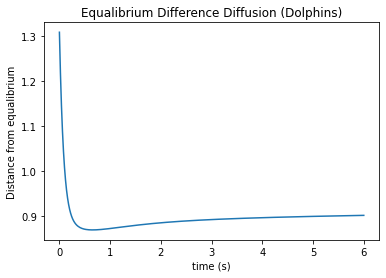

In [51]:
plt.figure()
plt.plot(time, eq_diff)
plt.xlabel('time (s)')
plt.ylabel('Distance from equalibrium')
plt.title('Equalibrium Difference Diffusion (Dolphins)')
plt.show()

## Other Models

In [52]:
runCChange = True
runTrain = True
runMacaque = True

In [ ]:
if runCChange:
    

## SI Model

Simulating SI model...

## SIR Model

Simulating SIR model...

## Independent Cascade

The following function implements an influence cascade model on the graph `G` and initial active node set `x` with the same probability `p` to activate a neighbor node along each edge.

In [ ]:
# G: Graph
# p: uniform probability to activate across an edge
# x: initial active seed set (as a list/array)
def influence_cascade(G,p,x):
    G = deepcopy(G)
    x = deepcopy(x)
    activated_nodes = set([])
    for i,xi in enumerate(x):
        if xi > 0:
            activated_nodes.add(G.node_by_index(i))

    while len(activated_nodes) > 0:
        newly_activated = set([])
        for u in activated_nodes:
            x[G.node_index(u)] = 1
            nbrs = G.neighbors(u)
            to_rm = set([])
            for v in nbrs:
                if random.random() <= p:
                    newly_activated.add(v)
                to_rm.add((u,v))
            G.remove_edges_from(to_rm)
        activated_nodes = newly_activated
        #print sum(x)
    return x

Repeating the influence cascade many times...

Using a percolation approach...